In [8]:
import pandas as pd

# Load your data (adjust the path as needed)
wapo_data = pd.read_csv('../benchmark_data/fatal-police-shootings-data.csv')
police_dept = pd.read_csv('../benchmark_data/fatal-police-shootings-agencies.csv')
# print(wapo_data)
# Define common suffixes to ignore
common_suffixes = ['Jr', 'Sr', 'II', 'III', 'IV', 'V']

# Define a function that processes each name
def process_name(name):
    # Ensure name is a string and not NaN or any float value
    if pd.isnull(name):
        # Handle NaN values or any other non-string values
        return [None, None]  # Or return ['Unknown', 'Unknown'] based on your preference
    else:
        # Convert to string in case it's not (handles numeric values)
        name = str(name)
        # Split the name into parts
        parts = name.split()
        # Check and construct the name ignoring common suffixes and middle names
        if parts[-1] in common_suffixes and len(parts) > 2:
            first_last_name = f"{parts[0]} {parts[-2]}"
        elif len(parts) > 2:
            first_last_name = f"{parts[0]} {parts[-1]}"
        else:
            first_last_name = name
        # Return a list with the original name, the first-last name version, and the version ignoring suffixes
        return [name, first_last_name]

# Apply the function to the 'name' column and create a new column with the results
wapo_data['names'] = wapo_data['name'].apply(process_name)
# wapo_data['date'] = pd.to_datetime(wapo_data['date'])
wapo_data = wapo_data[(wapo_data['date'] >= '2023-12-15') & (wapo_data['date'] <= '2023-12-30')]

result = pd.read_csv('../data_storage/20240306143757_test_weaviate_result.csv')
# result['publication_date'] = pd.to_datetime(result['publication_date'])
wapo_data.reset_index(drop=True, inplace=True)

# wapo_data

import numpy as np
from dateutil import tz


def parse_closest_date(wapo_date, publication_dates_str):
    # Ensure wapo_date is tz-naive
    wapo_date = wapo_date.replace(tzinfo=None)
    
    # Split the string into individual dates and remove any whitespace
    date_str_list = publication_dates_str.strip().replace('(', '').replace(')', '').split(',')
    
    # Convert string dates to datetime and ensure they are tz-naive
    date_diffs = [abs(wapo_date - pd.to_datetime(date_str.strip(), utc=True).replace(tzinfo=None)).days for date_str in date_str_list]
    
    # Return the date with the minimum difference
    min_diff_index = np.argmin(date_diffs)
    return pd.to_datetime(date_str_list[min_diff_index].strip(), utc=True).replace(tzinfo=None)

In [9]:
# Assuming the preparation steps have been done as in your provided code

# Helper function to check conditions
def check_conditions(row, results_df, police_dept):
    # Ensure 'names' is a list of strings, filtering out any None values
    names = [str(name) for name in row['names'] if pd.notnull(name)]
    
    # Check if any name in 'names' appears in 'snippet'
    for name in names:
        if any(name in str(snippet) for snippet in results_df['snippet']):
            return True
    
    # Convert 'date' to datetime for comparison
    wapo_date = pd.to_datetime(row['date'])
    
    # Ensure 'city' and 'county' are strings, handling potential NaN values
    city = str(row['city']) if pd.notnull(row['city']) else ""
    county = str(row['county']) if pd.notnull(row['county']) else ""
    
    # Check if 'city' appears in 'snippet' and dates within 7 days
    city_condition = results_df.apply(lambda x: city in str(x['snippet']) and abs((wapo_date - parse_closest_date(wapo_date, x['publication_date'])).days) <= 7, axis=1)
    if city_condition.any():
        return True
    
    # Check if 'county' appears in 'snippet' and dates within 5 days
    county_condition = results_df.apply(lambda x: county in str(x['snippet']) and abs((wapo_date - parse_closest_date(wapo_date, x['publication_date'])).days) <= 5, axis=1)
    if county_condition.any():
        return True
    
    agency_id = row['agency_ids']
    if pd.notnull(agency_id):
        # Find the corresponding name in 'police_dept' for the given 'agency_id'
        agency_name = police_dept.loc[police_dept['id'] == agency_id, 'name'].values
        if len(agency_name) > 0:  # Ensure there is a match
            agency_name = str(agency_name[0])  # Convert to string in case it's not
            # Check if the agency name appears in 'snippet' and dates within 5 days
            agency_condition = results_df.apply(lambda x: agency_name in str(x['snippet']) and abs((wapo_date - parse_closest_date(wapo_date, x['publication_date'])).days) <= 5, axis=1)
            if agency_condition.any():
                return True

    # If none of the conditions are met
    return False


# Apply the helper function to each row in wapo_data
wapo_data['condition_met'] = wapo_data.apply(check_conditions, results_df=result, police_dept=police_dept, axis=1)

idx = wapo_data.index[wapo_data['condition_met']]
print(idx)

# Print summary
true_count = wapo_data['condition_met'].sum()
total_rows = len(wapo_data)
print(f"True conditions: {true_count} out of {total_rows} rows.")


Index([ 1,  2,  4,  5,  7,  8,  9, 10, 14, 15, 16, 18, 23, 25, 26, 32, 33, 35,
       36, 38, 39, 41, 42, 43, 44, 45, 47, 48, 51],
      dtype='int64')
True conditions: 29 out of 53 rows.


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<html dir="ltr" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://ogp.me/ns/fb#" xmlns:og="http://ogp.me/ns#">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>LegiScan | Bringing People to the Process</title>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="/sites/legiscan.com/themes/legiscan/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/sites/legiscan.com/files/css/css_06ce2768739dd707677b9bc090629995.css" media="all" rel="stylesheet" type="text/css"/>
<link href="/sites/legiscan.com/files/css/css_2d21434a0159ff21eb8184ca701207ff.css" media="screen" rel="stylesheet" type="text/css"/>
<link href="/sites/legiscan.com/files/css/css_5ec1956a7f1d5e04cbf5c7c05152b2c0.css" media="print" rel="stylesheet" t
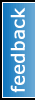

In [9]:
import requests
from bs4 import BeautifulSoup

# URL of the page to scrape
url = "https://legiscan.com/NY/text/A09614/id/2968236"

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the page
soup = BeautifulSoup(response.content, 'html.parser')
print(soup)
# Find the div with id 'billtext'
bill_text_div = soup.find('div', class_='billtext')
print(bill_text_div)

# # Remove all <style> and <font> tags and their content
# for tag in bill_text_div.find_all(['style', 'font']):
#     tag.decompose()

# # Get the text content of the div, excluding the removed tags
# bill_text = bill_text_div.get_text()

# print(bill_text)



In [19]:
from datetime import datetime
import pandas as pd
import requests
from tqdm import tqdm
# import unicodedata
from sentence_transformers import SentenceTransformer
from InstructorEmbedding import INSTRUCTOR

import weaviate
import json
import os
from dotenv import load_dotenv


load_dotenv()
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
weaviate_api_key = os.getenv('WEAVIATE_API_KEY')
weaviate_url = os.getenv('WEAVIATE_URL')
openai_key = os.getenv('OPENAI_API_KEY')
billtrack50_api_key = os.getenv('bill_tracker_api_key')

client = weaviate.Client(
    url = weaviate_url,
    auth_client_secret=weaviate.AuthApiKey(api_key=weaviate_api_key), 
    additional_headers = {
        "X-OpenAI-Api-Key": openai_key
    }
)


state = "NY"
# Configuration for API requests
api_url = "https://www.billtrack50.com/bt50api/2.1/json/bills"
params = {
    "searchText": "sex",
    "stateCodes": state
}
headers = {
    "Authorization": f"apiKey {billtrack50_api_key}"
}

# Initialize DataFrame to store combined data
combined_results = pd.DataFrame()

# Implement pagination
current_page = 1
total_pages = None  # We'll update this based on the API responses

while total_pages is None or current_page <= total_pages:
    print(f"Fetching data for page {current_page}...")
    response = requests.get(api_url, headers=headers, params={**params, "page": current_page})
    if response.status_code == 200:
        data = response.json()
        if total_pages is None:
            # Assuming the API provides total pages directly
            total_pages = data.get('totalPages', 1)
        bills = data['bills']
        combined_results = pd.concat([combined_results, pd.DataFrame(bills)], ignore_index=True)
        current_page += 1
    else:
        print(f"Failed to fetch data for page {current_page}. Status Code: {response.status_code}")
        break

print("Shape of result dataframe:", combined_results.shape)
print(combined_results.head())
combined_results.to_csv(f'../data_storage/legislation/{state}_billtrack50_results.csv', index=False)
# combined_results = pd.read_csv('./data_storage/legislation/billtrack50_results.csv')


/Users/karenwang/.virtualenvs/semantic-search/lib/python3.11/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


Fetching data for page 1...
Shape of result dataframe: (250, 22)
    billID stateBillID stateCode  \
0  1505347      A00037        NY   
1  1505359      A00063        NY   
2  1506131      A00151        NY   
3  1506034      A00162        NY   
4  1506226      A00200        NY   

                                            billName  \
0  Removes from admissibility evidence that prove...   
1  Requires that all female-designated and gender...   
2  Provides that possession of a condom or other ...   
3  Provides for findings of the state board of pa...   
4  Provides employers with a tax credit in an amo...   

                                             summary  \
0  AN ACT to amend the criminal procedure law, in...   
1  AN ACT to amend the labor law, the general mun...   
2  AN ACT to amend the civil practice law and rul...   
3  AN ACT to amend the executive law, in relation...   
4  AN ACT to amend the tax law, in relation to pr...   

                      session  sponsorCount 

In [51]:
import pandas as pd


df = pd.read_csv('../data_storage/legislation/full_text.csv', encoding='latin-1', on_bad_lines='warn')

# df = pd.read_csv('../data_storage/legislation/cleaned_full_text.txt', sep='|', encoding='unicode_escape', on_bad_lines='warn')
# column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']
# df = pd.DataFrame(records, columns=column_names)
# df = df.dropna(subset=['BillID'])

df.head()


# df.to_csv('../data_storage/legislation/full_text.csv', index=False)


Shape of the original DataFrame: (8121, 11)
Shape of the DataFrame after filtering columns: (8121, 11)


In [56]:
df = pd.read_csv('../data_storage/legislation/full_text.txt', encoding='latin-1', on_bad_lines='warn', sep='|')
print("Shape of the original DataFrame:", df.shape)
column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']
df = pd.DataFrame(df, columns=column_names)
print("Shape of the DataFrame after filtering columns:", df.shape)

df.to_csv('../data_storage/legislation/cleaned_full_text.csv', index=False)



Skipping line 2987: expected 12 fields, saw 13



Shape of the original DataFrame: (14333, 12)
Shape of the DataFrame after filtering columns: (14333, 12)


In [34]:
def custom_csv_reader(filepath, delimiter='|'):
    """Reads a CSV file that uses delimiters but might have unquoted new lines within fields."""
    with open(filepath, 'r', encoding='unicode_escape') as file:
        current_record = []  # Store the current record being processed
        for line in file:
            # Split line by delimiter and strip to remove potential trailing new line
            parts = [part.strip() for part in line.split(delimiter)]
            
            # If line starts a new record (based on some condition), yield the previous record
            if line.startswith(delimiter) or (len(current_record) > 0 and len(parts) == 12):
                yield current_record
                current_record = parts
            else:
                # If the line is part of the current record, append it to the last element of current_record
                if len(current_record) > 0:
                    current_record[-1] += ' ' + line.strip()
                else:
                    current_record = parts
        
        # Don't forget to yield the last record
        if current_record:
            yield current_record

# Use the custom reader to process the file
file_path = '../data_storage/legislation/full_text.txt'
records = list(custom_csv_reader(file_path))

# Now you can manually convert these records into a DataFrame
import pandas as pd

# Assuming you know the structure of your data and column names
column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']
df = pd.DataFrame(records, columns=column_names)
df.to_csv('../data_storage/legislation/full_text.csv', index=False)


In [62]:
# file_path = '../data_storage/legislation/full_text.txt'
# output_path = '../data_storage/legislation/full_text_single_line.txt'

# # Read the file and remove newlines
# with open(file_path, 'r', encoding='unicode_escape') as file:
#     content = file.read().replace('\n', '')

# # Optionally, write the single-line content to a new file
# with open(output_path, 'w', encoding='unicode_escape') as file:
#     file.write(content)

# # If you just want to work with the content as a single string, `content` now contains it
# print(content)

with open(output_path, 'r', encoding='unicode_escape') as file:
    line = file.readline().strip()

fields_per_record = 12
data = [line.split('|')[i:i + fields_per_record] for i in range(0, len(line.split('|')), fields_per_record)]


# Create a DataFrame from this data
# You'll need to manually specify the column names if they're not included in your data
column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']
df = pd.DataFrame(data, columns=column_names)

print(df.head())


# df = pd.read_csv('../data_storage/legislation/full_text_single_line.txt', encoding='unicode_escape', on_bad_lines='warn', sep='|')
# # print("Shape of the original DataFrame:", df.shape)
# df.head()
# column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']
# df = pd.DataFrame(df, columns=column_names)
# print("Shape of the DataFrame after filtering columns:", df.shape)

# df.to_csv('../data_storage/legislation/cleaned_full_text.csv', index=False)



                          BillID                      StateCode  \
0                         BillID                      StateCode   
1                             IL                         HB0041   
2                         HB0048  EXPUNGEMENT-SUSPENDED LICENSE   
3  ISOLATED CONFINEMENT RESTRICT  2022-12-05 18:00:57.813000000   
4  2022-12-05 18:00:57.813000000                              D   

                     StateBillID                  ShortBillName       Created  \
0                    StateBillID                  ShortBillName       Created   
1  IMDMA-PARENT RESPONSIBILITIES  2022-12-05 18:00:57.813000000             B   
2  2022-12-05 18:00:57.813000000                              D          Bill   
3                              D                           Bill  In Committee   
4                           Bill                   In Committee       Justice   

                                        SponsorParty  \
0                                       SponsorParty  

In [63]:
df.to_csv('../data_storage/legislation/cleaned_full_text.csv', index=False)


In [74]:
import pandas as pd
import csv

file_path = '../data_storage/legislation/full_text.csv'

# Initialize an empty list to hold the processed rows
processed_rows = []

# Define your column names
column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'BillTextCurrent']

# Read the file line by line
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    next(file)  # Skip header line if your CSV contains headers
    for line in file:
        # Split the line by comma, but limit the splits to len(column_names)-1 to ensure all extra splits are captured in the last column
        parts = line.strip().split(',', len(column_names) - 1)
        
        # Check if there are more parts than columns, which should not happen after the correct split
        if len(parts) > len(column_names):
            # Concatenate any parts beyond the 11th (index 10) into the 'BillTextCurrent' column
            parts[10:] = [','.join(parts[10:])]
        
        # Add the processed row to the list
        processed_rows.append(parts)

# Create a DataFrame from the processed rows
df = pd.DataFrame(processed_rows, columns=column_names)

# for column in df.columns:
    # df[column] = df[column].str.strip('"')
    
print(df.head())
# df.to_csv('../data_storage/legislation/cleaned_full_text.csv', index=False, quoting=csv.QUOTE_MINIMAL)



      BillID StateCode StateBillID                    ShortBillName  \
0  "1499673"      "IL"    "HB0041"  "IMDMA-PARENT RESPONSIBILITIES"   
1  "1499678"      "IL"    "HB0048"  "EXPUNGEMENT-SUSPENDED LICENSE"   
2  "1499693"      "IL"    "HB0046"  "ISOLATED CONFINEMENT RESTRICT"   
3  "1499704"      "IL"    "HB0028"            "CRIM ID-EXPUNGEMENT"   
4  "1499916"      "IL"    "HB0003"            "REPRODUCTIVE HEALTH"   

                           Created SponsorParty billtype          status  \
0  "2022-12-05 18:00:57.813000000"          "B"   "Bill"  "In Committee"   
1  "2022-12-05 18:00:57.813000000"          "D"   "Bill"  "In Committee"   
2  "2022-12-05 18:00:57.813000000"          "D"   "Bill"  "In Committee"   
3  "2022-12-05 18:00:57.813000000"          "D"   "Bill"  "In Committee"   
4  "2022-12-05 18:00:57.813000000"          "D"   "Bill"  "In Committee"   

            CommitteeCategories  \
0                     "Justice"   
1                     "Justice"   
2          

In [75]:
import pandas as pd

# Assuming df is your DataFrame and it's already loaded with data

# Function to count quotes in a string
def count_quotes(s):
    return s.count('"')

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Count quotes before stripping
    quotes_before = sum(row.apply(count_quotes))
    
    # Strip quotes and update the DataFrame row
    df.loc[index] = row.apply(lambda x: x.strip('"') if isinstance(x, str) else x)
    
    # Count quotes after stripping
    quotes_after = sum(df.loc[index].apply(count_quotes))
    
    # Calculate how many quotes were stripped in this row
    quotes_stripped = quotes_before - quotes_after
    
    # Print the result
    print(f"Row {index}: {quotes_stripped} quotes stripped")


Row 0: 20 quotes stripped
Row 1: 20 quotes stripped
Row 2: 20 quotes stripped
Row 3: 20 quotes stripped
Row 4: 20 quotes stripped
Row 5: 20 quotes stripped
Row 6: 20 quotes stripped
Row 7: 20 quotes stripped
Row 8: 20 quotes stripped
Row 9: 18 quotes stripped
Row 10: 20 quotes stripped
Row 11: 20 quotes stripped
Row 12: 20 quotes stripped
Row 13: 18 quotes stripped
Row 14: 18 quotes stripped
Row 15: 20 quotes stripped
Row 16: 20 quotes stripped
Row 17: 20 quotes stripped
Row 18: 16 quotes stripped
Row 19: 20 quotes stripped
Row 20: 20 quotes stripped
Row 21: 20 quotes stripped
Row 22: 22 quotes stripped
Row 23: 22 quotes stripped
Row 24: 20 quotes stripped
Row 25: 18 quotes stripped
Row 26: 18 quotes stripped
Row 27: 20 quotes stripped
Row 28: 20 quotes stripped
Row 29: 20 quotes stripped
Row 30: 22 quotes stripped
Row 31: 20 quotes stripped
Row 32: 20 quotes stripped
Row 33: 20 quotes stripped
Row 34: 20 quotes stripped
Row 35: 20 quotes stripped
Row 36: 22 quotes stripped
Row 37: 18 

AttributeError: 'NoneType' object has no attribute 'count'

In [77]:
import pandas as pd

file_path = '../data_storage/legislation/full_text.csv'

# Initialize an empty list to hold the processed rows
processed_rows = []

# Define your column names without 'aisummary'
column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'BillTextCurrent']

# Read the file line by line, specifying the correct encoding
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    next(file)  # Skip header line if your CSV contains headers
    for line in file:
        # Use rstrip() to remove trailing newline without touching other whitespace
        line = line.rstrip("\n")
        # Split the line by comma, limiting the splits to ensure all extra text goes into the last column
        parts = line.split(',', maxsplit=len(column_names) - 1)
        
        # Check and combine parts if more than expected to ensure correct column count
        if len(parts) > len(column_names):
            parts = parts[:10] + [','.join(parts[10:])]
        
        processed_rows.append(parts)

# Create a DataFrame from the processed rows
df = pd.DataFrame(processed_rows, columns=column_names)

for column in df.columns:
    df[column] = df[column].str.strip('"')
# Show the result
print(df.head())
df.to_csv('../data_storage/legislation/cleaned_full_text.csv', index=False)


    BillID StateCode StateBillID                  ShortBillName  \
0  1499673        IL      HB0041  IMDMA-PARENT RESPONSIBILITIES   
1  1499678        IL      HB0048  EXPUNGEMENT-SUSPENDED LICENSE   
2  1499693        IL      HB0046  ISOLATED CONFINEMENT RESTRICT   
3  1499704        IL      HB0028            CRIM ID-EXPUNGEMENT   
4  1499916        IL      HB0003            REPRODUCTIVE HEALTH   

                         Created SponsorParty billtype        status  \
0  2022-12-05 18:00:57.813000000            B     Bill  In Committee   
1  2022-12-05 18:00:57.813000000            D     Bill  In Committee   
2  2022-12-05 18:00:57.813000000            D     Bill  In Committee   
3  2022-12-05 18:00:57.813000000            D     Bill  In Committee   
4  2022-12-05 18:00:57.813000000            D     Bill  In Committee   

          CommitteeCategories  \
0                     Justice   
1                     Justice   
2          Government Affairs   
3                     Justice   

In [84]:
import csv
import pandas as pd
import sys

csv.field_size_limit(sys.maxsize)


file_path = '../data_storage/legislation/full_text.csv'  # Update this to your file path

# Prepare to read the file
data = []
with open(file_path, 'r', encoding='ISO-8859-1') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for row in reader:
        # Combine the 11th and beyond fields into the 11th field
        if len(row) > 11:
            row[10] = ','.join(row[10:])  # Combine and replace the 11th field with the combined text
            del row[11:]  # Remove the now combined fields

        data.append(row)

# Assuming the first row is the header
header = data[0]
rows = data[1:]

# Create a DataFrame
df = pd.DataFrame(rows, columns=header)

print(df.head())
df.to_csv('../data_storage/legislation/new_cleaned_full_text.csv', index=False)


    BillID StateCode StateBillID                  ShortBillName  \
0  1499673        IL      HB0041  IMDMA-PARENT RESPONSIBILITIES   
1  1499678        IL      HB0048  EXPUNGEMENT-SUSPENDED LICENSE   
2  1499693        IL      HB0046  ISOLATED CONFINEMENT RESTRICT   
3  1499704        IL      HB0028            CRIM ID-EXPUNGEMENT   
4  1499916        IL      HB0003            REPRODUCTIVE HEALTH   

                         Created SponsorParty billtype        status  \
0  2022-12-05 18:00:57.813000000            B     Bill  In Committee   
1  2022-12-05 18:00:57.813000000            D     Bill  In Committee   
2  2022-12-05 18:00:57.813000000            D     Bill  In Committee   
3  2022-12-05 18:00:57.813000000            D     Bill  In Committee   
4  2022-12-05 18:00:57.813000000            D     Bill  In Committee   

           CommitteeCategories  \
0                      Justice   
1                      Justice   
2  Government Affairs, Justice   
3                      Justi

In [90]:
df['BillTextCurrent'][2222]

"by amending section 2 (MCL 28.632), as amended by 2016 PA 284.,MI HB 4811 MI HB4811 MIHB4811 MI HB 4811 MI HB4811 MIHB4811 Public employees and officers: compensation and benefits; certain references in the public safety officers benefit act; make gender neutral. TIE BAR WITH: HJR F'23"

In [92]:
import pandas as pd
import csv
import pandas as pd
import sys

csv.field_size_limit(sys.maxsize)


# Define the file path and column names
file_path = '../data_storage/legislation/full_text.txt'
column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']

# Prepare to store processed lines
processed_data = []

# Open and read the file line by line
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Strip trailing newline and split by pipe
        parts = line.strip().split('|')
        
        # If there are more than 12 columns, combine the extras into the last one
        if len(parts) > 12:
            parts = parts[:11] + ['|'.join(parts[11:])]
        elif len(parts) < 12:
            # Handle lines with fewer than 12 parts if necessary, e.g., by appending empty strings
            parts += [''] * (12 - len(parts))
        
        # Append the processed line to the data list
        processed_data.append(parts)

# Create a DataFrame from the processed data
df = pd.DataFrame(processed_data, columns=column_names)

# Display the first few rows of the DataFrame to verify
print(df.head())
df.to_csv('../data_storage/legislation/txt_cleaned_full_text.csv', index=False)


    BillID  StateCode  StateBillID                  ShortBillName  \
0   BillID  StateCode  StateBillID                  ShortBillName   
1  1499673         IL       HB0041  IMDMA-PARENT RESPONSIBILITIES   
2  1499678         IL       HB0048  EXPUNGEMENT-SUSPENDED LICENSE   
3  1499693         IL       HB0046  ISOLATED CONFINEMENT RESTRICT   
4  1499704         IL       HB0028            CRIM ID-EXPUNGEMENT   

                         Created  SponsorParty  billtype        status  \
0                        Created  SponsorParty  billtype        status   
1  2022-12-05 18:00:57.813000000             B      Bill  In Committee   
2  2022-12-05 18:00:57.813000000             D      Bill  In Committee   
3  2022-12-05 18:00:57.813000000             D      Bill  In Committee   
4  2022-12-05 18:00:57.813000000             D      Bill  In Committee   

           CommitteeCategories  \
0          CommitteeCategories   
1                      Justice   
2                      Justice   
3  G

In [ ]:
import pandas as pd

file_path = '../data_storage/legislation/full_text.txt'
data = []  # To store the processed rows

with open(file_path, 'r', encoding='utf-8') as file:
    current_row = []  # Temporarily stores fields for the current row
    for line in file:
        if '|' in line:  # Check if the line contains a field delimiter
            parts = line.strip().split('|')
            # Handle incomplete previous row
            if current_row:
                current_row[-1] += ' ' + parts[0]  # Append to the last field of the current row
                current_row.extend(parts[1:])  # Extend the current row with new fields
            else:
                current_row = parts
            
            # If the row has all expected fields, save it and prepare for the next row
            if len(current_row) >= 12:
                # Ensure not to exceed the expected number of fields, combining extras if necessary
                if len(current_row) > 12:
                    current_row = current_row[:11] + ['|'.join(current_row[11:])]
                data.append(current_row[:12])  # Copy the first 12 fields to ensure row consistency
                current_row = current_row[12:] if len(current_row) > 12 else []
        else:
            # If no delimiter is present, assume the line is part of the last field
            if current_row:
                current_row[-1] += ' ' + line.strip()

# Ensure the last row is not missed
if current_row:
    if len(current_row) > 12:
        current_row = current_row[:11] + ['|'.join(current_row[11:])]
    data.append(current_row)

column_names = ['BillID', 'StateCode', 'StateBillID', 'ShortBillName', 'Created', 'SponsorParty', 'billtype', 'status', 'CommitteeCategories', 'statesummary', 'aisummary', 'BillTextCurrent']
df = pd.DataFrame(data, columns=column_names)

print(df.head())
df.to_csv('../data_storage/legislation/txt_cleaned_full_text.csv', index=False)
